In [ ]:
import datetime
import os

import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import requests_cache
import openmeteo_requests
import seaborn as sns
from dotenv import load_dotenv
from folium.plugins import HeatMap
from IPython.display import HTML
from io import StringIO
from ipywidgets import interact, widgets
from retry_requests import retry
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# Load environment variables
load_dotenv()

# Set up requests cache
requests_cache.install_cache()


# Footpath Steepness dataset

In [ ]:

load_dotenv()
api_key = os.environ.get("API_KEY_MOP")

base_url = 'https://melbournetestbed.opendatasoft.com/api/explore/v2.1/catalog/datasets/'
dataset_id = 'footpath-steepness'
apikey = api_key
dataset_id = dataset_id
format = 'csv'

params = {
    'select': '*',
    'limit': -1,  # all records
    'lang': 'en',
    'timezone': 'UTC',
    'api_key': apikey
}
url = f'{base_url}{dataset_id}/exports/{format}'
#GET request
response = requests.get(url, params=params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    footpath_steepness = pd.read_csv(StringIO(url_content), delimiter=';')
    print(footpath_steepness.sample(10, random_state=999)) # Test
else:
    print(f'Request failed with status code {response.status_code}')



In [186]:
footpath_steepness


,geo_point_2d,geo_shape,grade1in,gradepc,segside,statusid,asset_type,deltaz,streetid,mccid_int,mcc_id,address,rlmax,rlmin,distance
0,"-37.823036142583945, 144.94866061456034","{""coordinates"": [[[[144.94865791889143, -37.82...",4.2,23.81,NaN,8.0,Road Footway,6.77,3094.0,30821.0,1388075,Yarra River,6.86,0.09,28.43
1,"-37.79542957518662, 144.91714933764632","{""coordinates"": [[[[144.9171360775573, -37.795...",NaN,NaN,NaN,NaN,Road Footway,NaN,NaN,NaN,1534622,NaN,NaN,NaN,NaN
2,"-37.79544286753349, 144.9172426574227","{""coordinates"": [[[[144.917238930522, -37.7954...",NaN,NaN,NaN,NaN,Road Footway,NaN,NaN,NaN,1534622,NaN,NaN,NaN,NaN
3,"-37.79580169415494, 144.92075182140118","{""coordinates"": [[[144.92074176246658, -37.795...",35.1,2.85,NaN,NaN,Road Footway,0.23,NaN,NaN,1387592,NaN,2.78,2.55,8.07
4,"-37.79654832375531, 144.92328274904054","{""coordinates"": [[[[144.92328246984576, -37.79...",109.6,0.91,NaN,NaN,Road Footway,0.01,NaN,NaN,1387085,NaN,3.39,3.38,1.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33580,"-37.80166668168155, 144.94353746774505","{""coordinates"": [[[[144.94350389586447, -37.80...",NaN,NaN,NaN,NaN,Road Footway,NaN,NaN,NaN,1385182,NaN,NaN,NaN,NaN
33581,"-37.80169795826924, 144.9433029188373","{""coordinates"": [[[[144.9433008833934, -37.801...",NaN,NaN,NaN,4.0,Road Footway,NaN,2987.0,30333.0,1385189,Pl5230,NaN,NaN,NaN
33582,"-37.802241487751616, 144.9434698881252",NaN,23.3,4.30,NaN,NaN,Road Footway,2.20,NaN,NaN,1385334,NaN,15.15,12.95,51.21
33583,"-37.8024821678599, 144.94316039147643","{""coordinates"": [[[[144.94311328357037, -37.80...",20.2,4.94,NaN,NaN,Road Footway,1.00,NaN,NaN,1385191,NaN,15.95,14.95,20.25


# Pedestrian monthly Counts per hour dataset

In [ ]:

load_dotenv()
api_key = os.environ.get("API_KEY_MOP")

base_url = 'https://melbournetestbed.opendatasoft.com/api/explore/v2.1/catalog/datasets/'
dataset_id = 'pedestrian-counting-system-monthly-counts-per-hour'
apikey = api_key
dataset_id = dataset_id
format = 'csv'

params = {
    'select': '*',
    'limit': -1,  # all records
    'lang': 'en',
    'timezone': 'UTC',
    'api_key': apikey
}
url = f'{base_url}{dataset_id}/exports/{format}'
# GET request
response = requests.get(url, params=params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    pedestrian_count = pd.read_csv(StringIO(url_content), delimiter=';')

    pedestrian_count['timestamp'] = pd.to_datetime(pedestrian_count['timestamp'])
    all_hours = pd.date_range(start=pedestrian_count['timestamp'].min(), end=pedestrian_count['timestamp'].max(), freq='1H')
    all_hours_df = pd.DataFrame({'timestamp': all_hours})
    
    # Merge with original DataFrame to fill in missing rows
    pedestrian_count = pd.merge(all_hours_df, pedestrian_count, on='timestamp', how='left')
    
    # Fill NaN values with 0
    pedestrian_count.fillna(0, inplace=True)
    
    print(pedestrian_count)

    print(pedestrian_count.sample(10, random_state=999)) # Test
    
else:
    print(f'Request failed with status code {response.status_code}')

In [ ]:
all_hours

In [ ]:
zero_count = (pedestrian_count == 0).sum()
zero_count

# Pedestrian Couting system location dataset

In [ ]:

load_dotenv()
api_key = os.environ.get("API_KEY_MOP")

base_url = 'https://melbournetestbed.opendatasoft.com/api/explore/v2.1/catalog/datasets/'
dataset_id = 'pedestrian-counting-system-sensor-locations'
apikey = api_key
dataset_id = dataset_id
format = 'csv'

params = {
    'select': '*',
    'limit': -1,  # all records
    'lang': 'en',
    'timezone': 'UTC',
    'api_key': apikey
}
url = f'{base_url}{dataset_id}/exports/{format}'
# GET request
response = requests.get(url, params=params)

if response.status_code == 200:
    # StringIO to read the CSV data
    url_content = response.content.decode('utf-8')
    pedestrian_sensor_locations = pd.read_csv(StringIO(url_content), delimiter=';')
    print(pedestrian_sensor_locations.sample(10, random_state=999)) # Test
else:
    print(f'Request failed with status code {response.status_code}')

# merge pedestrian counts and locations

In [ ]:
pedestrian_merged_data = pd.merge(pedestrian_count, pedestrian_sensor_locations, left_on='locationid', right_on='location_id', how='inner')
pedestrian_merged_data
# pedestrian_merged_data.info()
# print(type(pedestrian_merged_data.timestamp[0]))
# pedestrian_merged_data['timestamp'] = pd.to_datetime(pedestrian_merged_data['timestamp'])
# print(type(pedestrian_merged_data.timestamp[0]))

pedestrian_merged_data.sort_values(by='timestamp',ascending=False)
# print(pedestrian_merged_data)

In [ ]:
# Convert 'timestamp' column to datetime if needed
pedestrian_merged_data['timestamp'] = pd.to_datetime(pedestrian_merged_data['timestamp'])

# Find the earliest and latest timestamps
earliest_timestamp = pedestrian_merged_data['timestamp'].min()
latest_timestamp = pedestrian_merged_data['timestamp'].max()

print("Earliest Timestamp:", earliest_timestamp)
print("Latest Timestamp:", latest_timestamp)


# filter data by date

In [ ]:
# Assuming pedestrian_merged_data is your DataFrame containing the pedestrian data

# Define the start and end dates for filtering
start_date = pd.to_datetime('2024-01-02').date()
end_date = pd.to_datetime('2024-03-18').date()

# Convert 'timestamp' column to datetime if it's not already
pedestrian_merged_data['timestamp'] = pd.to_datetime(pedestrian_merged_data['timestamp'])

# Extract date from 'timestamp' column
pedestrian_merged_data['date_only'] = pedestrian_merged_data['timestamp'].dt.date

# Dictionary to store filtered DataFrames
filtered_data_dfs = {}

# Iterate over dates in 7-day intervals and filter data
current_date = start_date
week_number = 1
while current_date <= end_date:
    # Define the end date of the current 7-day period
    period_end_date = current_date + pd.Timedelta(days=6)  # 6 days later
    
    # Define the name for the DataFrame
    month_name = current_date.strftime('%B')
    df_name = f"{month_name}_{week_number}"
    
    # Filter the combined data DataFrame by date range
    filtered_data_dfs[df_name] = pedestrian_merged_data[
        (pedestrian_merged_data['date_only'] >= current_date) & 
        (pedestrian_merged_data['date_only'] <= period_end_date)
    ]
    
    # Move to the next 7-day period
    current_date += pd.Timedelta(days=7)
    week_number += 1

# Now, filtered_data_dfs contains DataFrames for each 7-day period within the specified range,
# and they are accessible using the formatted name, e.g., filtered_data_dfs['January_1'], filtered_data_dfs['January_2'], and so on.


In [ ]:


# Define an empty list to store keys within the date range
keys_within_date_range = []

# Iterate over the keys of filtered_data_dfs and select only those keys within the specified date range
for key in filtered_data_dfs.keys():
    month, week = key.split('_')
    week_start_date = datetime.datetime.strptime(f"{month} {week.split()[0]} {start_date.year}", '%B %d %Y').date()
    week_end_date = week_start_date + datetime.timedelta(days=6)
    if week_start_date >= start_date and week_end_date <= end_date:
        keys_within_date_range.append(key)

# Now, keys_within_date_range contains the keys representing month names and week numbers that fall within the specified date range.


In [ ]:
# Get all keys from the filtered_data_dfs dictionary
all_keys = list(filtered_data_dfs.keys())

# Create a DataFrame with the keys
keys_df = pd.DataFrame(all_keys, columns=['Keys'])

# Print the DataFrame
print(keys_df)


# Dictionary used to store weekly DataFrame accessed by the keys

In [ ]:
week_dataframes = {}

# Loop through each key in the DataFrame keys_df
for index, row in keys_df.iterrows():
    week_key = row['Keys']
    
    # Access the corresponding DataFrame from filtered_data_dfs using the week_key
    weekly_dataframe = filtered_data_dfs[week_key]
    
    # Store the DataFrame in a new dictionary for easy access
    week_dataframes[week_key] = weekly_dataframe
    


In [ ]:
week_dataframes['January_4']

# drop unwanted columns

In [ ]:
week_dataframes[week_key] = week_dataframes[week_key].reindex(columns=['timestamp','location_id', 'latitude', 'longitude', 'direction_1_x', 'direction_2_x', 'total_of_directions', 'direction_1_y', 'direction_2_y', 'date_only'])
week_dataframes[week_key]


# Weekly Date Filtered Pedestrian data with location

In [ ]:
# # Initialize an empty dictionary to store the DataFrames
# filtered_pedestrian_merged_data = {}

# # Iterate through each row in keys_df
# for index, row in keys_df.iterrows():
#     # Get the key value from the current row
#     selected_key = row['Keys']
    
#     # Use the selected key to access the corresponding DataFrame from filtered_data_dfs
#     filtered_pedestrian_merged_data[selected_key] = filtered_data_dfs[selected_key]

# # Now you have a dictionary of DataFrames where keys are the keys from keys_df
# # and values are corresponding DataFrames from filtered_data_dfs

# # You can access each DataFrame using the key, for example:
# filtered_pedestrian_merged_data[selected_key]


# Request climate data through API using latitude and longitude data

In [ ]:
pedestrian_latitude = pedestrian_sensor_locations['latitude'].values[0]
pedestrian_longitude = pedestrian_sensor_locations['longitude'].values[0]

In [ ]:

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

def get_climate_data(latitude, longitude):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": pedestrian_latitude,
        "longitude": pedestrian_longitude,
        "current": "relative_humidity_2m",
        "hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "rain", "showers", "weather_code", "uv_index"],
        "past_days": 92
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process hourly data
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
    hourly_rain = hourly.Variables(3).ValuesAsNumpy()
    hourly_showers = hourly.Variables(4).ValuesAsNumpy()
    hourly_weather_code = hourly.Variables(5).ValuesAsNumpy()
    hourly_uv_index = hourly.Variables(6).ValuesAsNumpy()

    hourly_data = {
        "latitude": latitude,
        "longitude": longitude,
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ),
        "temperature_2m": hourly_temperature_2m,
        "relative_humidity_2m": hourly_relative_humidity_2m,
        "precipitation": hourly_precipitation,
        "rain": hourly_rain,
        "showers": hourly_showers,
        "weather_code": hourly_weather_code,
        "uv_index": hourly_uv_index
    }

    hourly_dataframe = pd.DataFrame(data=hourly_data)
    return hourly_dataframe


# Initialize an empty list to store all climate dataframes
all_climate_data = []

# Iterate over each location and retrieve climate data
for index, row in pedestrian_sensor_locations.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
   
    climate_data = get_climate_data(latitude, longitude)
    all_climate_data.append(climate_data)

# Concatenate all climate dataframes into a single dataframe
climate_data_combined = pd.concat(all_climate_data, ignore_index=True)

# Print the combined climate data

climate_data_combined = climate_data_combined.rename(columns={'date': 'timestamp'})
climate_data_combined

# Check the time range

In [ ]:
# Convert 'timestamp' column to datetime if needed
climate_data_combined['timestamp'] = pd.to_datetime(climate_data_combined['timestamp'])

# Find the earliest and latest timestamps
earliest_timestamp = climate_data_combined['timestamp'].min()
latest_timestamp = climate_data_combined['timestamp'].max()

print("Earliest Timestamp:", earliest_timestamp)
print("Latest Timestamp:", latest_timestamp)

# merge pedestrian dataset with climate dataset on timestamp and location data

In [ ]:
#Assuming climate_data_combined is already loaded and in the correct format
climate_data_combined['timestamp'] = pd.to_datetime(climate_data_combined['timestamp'], utc=True)

# Dictionary to store merged dataframes, initialized from previous steps if any
merged_dataframes = {}

# Iterate over the keys from keys_df DataFrame
for index, row in keys_df.iterrows():
    week_key = row['Keys']
    week_df = week_dataframes[week_key]  # Access the corresponding DataFrame using the week_key from keys_df

    # Convert timestamps in the week DataFrame
    week_df.loc[:, 'timestamp'] = pd.to_datetime(week_df['timestamp'], utc=True)


    # Filter climate data to match the date range of week_df
    start_date = week_df['timestamp'].min()
    end_date = week_df['timestamp'].max()
    filtered_climate_data = climate_data_combined[(climate_data_combined['timestamp'] >= start_date) & (climate_data_combined['timestamp'] <= end_date)]

    # Join the data on timestamp and location (latitude and longitude)
    merged_data = pd.merge(filtered_climate_data, week_df, on=['timestamp', 'latitude', 'longitude'])

    # Store the merged DataFrame in the dictionary using the week_key
    merged_dataframes[week_key] = merged_data

# Now merged_dataframes contains all the merged data for each week_key as per keys_df


In [ ]:
merged_dataframes['January_4']

# Check Columns

In [ ]:
merged_dataframes['January_4'].columns

# Reindexing the dataframe

In [ ]:
merged_dataframes[week_key] = merged_dataframes[week_key].reindex(columns=['latitude', 'longitude','timestamp','location_id', 'direction_1_x', 'direction_2_x', 'total_of_directions', 'direction_1_y', 'direction_2_y','temperature_2m',
       'relative_humidity_2m', 'precipitation', 'rain', 'showers','weather_code', 'uv_index', ]) 
merged_dataframes[week_key]

In [ ]:
merged_dataframes[week_key]

In [ ]:
# Find the earliest and latest timestamps
earliest_timestamp = merged_dataframes[week_key]['timestamp'].min()
latest_timestamp = merged_dataframes[week_key]['timestamp'].max()

print("Earliest Timestamp:", earliest_timestamp)
print("Latest Timestamp:", latest_timestamp)

In [ ]:
keys_df.keys

In [ ]:
zero_count = (merged_dataframes[week_key] == 0).sum()
zero_count

# Create a base map centered around Melbourne

In [ ]:

melbourne_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=15)

# Filter out duplicate latitude and longitude coordinates
unique_coordinates = merged_dataframes['January_4'][['latitude', 'longitude']].drop_duplicates().values.tolist()

# Add unique coordinates as markers on the map
for lat, lon in unique_coordinates:
    folium.Marker(location=[lat, lon]).add_to(melbourne_map)

# Save the map to an HTML file
# melbourne_map.save("melbourne_map_with_unique_coordinates.html")
melbourne_map

# Total of Directions Heat Map

In [ ]:
# Function to update the map based on the selected date
def update_map(selected_date):
    selected_day_df = merged_dataframes[week_key][merged_dataframes[week_key]['timestamp'].dt.date == selected_date]
    pedestrian_data = selected_day_df[['latitude', 'longitude', 'total_of_directions']].values.tolist()
    
    # Create base map centered around Melbourne
    melbourne_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=16)

    # Add heatmap layer using pedestrian data
    HeatMap(pedestrian_data).add_to(melbourne_map)

    # Save the map as HTML
    # melbourne_map.save("melbourne_heatmap.html")
    display(melbourne_map)

# Create a widget to select the date
date_picker = widgets.DatePicker(description='Select Date', disabled=False)

# Display the time range
print("Time Range:")
print("Earliest Timestamp:", earliest_timestamp)
print("Latest Timestamp:", latest_timestamp)

# Display the widget and the interactive map
#display(date_picker)
interact(update_map, selected_date=date_picker);


# HeatMap with Climate Data

In [194]:

# Function to update the map based on the selected date
def update_map(selected_date):
    # Filter data for the selected date
    selected_day_df = merged_dataframes[week_key][merged_dataframes[week_key]['timestamp'].dt.date == selected_date]
    
    # Extract pedestrian data
    pedestrian_data = selected_day_df[['latitude', 'longitude', 'total_of_directions']].values.tolist()
    
    # Create base map centered around Melbourne
    melbourne_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=16)
    
    # Add heatmap layer for pedestrian data
    HeatMap(pedestrian_data, name='Pedestrian Heatmap').add_to(melbourne_map)
    
    # Add climate data layers
    climate_layers = {
        'Relative Humidity 2m': 'relative_humidity_2m',
        'Precipitation': 'precipitation',
        'Rain': 'rain',
        'Showers': 'showers',
        'UV Index': 'uv_index'
    }
    
    for layer_name, layer_column in climate_layers.items():
        climate_data = selected_day_df[['latitude', 'longitude', layer_column]].values.tolist()
        HeatMap(climate_data, name=layer_name).add_to(melbourne_map)

    # Add layer control
    folium.LayerControl().add_to(melbourne_map)

    # Save the map as HTML
    # melbourne_map.save("melbourne_heatmap.html")
    display(melbourne_map)

merged_dataframes[week_key].dropna(inplace=True)

# Get unique dates from the DataFrame
unique_dates = merged_dataframes[week_key]['timestamp'].dt.date.unique()

# Create a widget to select the date
date_picker = widgets.DatePicker(description='Select Date', disabled=False)


# Display the time range
print("Time Range:")
print("Earliest Timestamp:", earliest_timestamp)
print("Latest Timestamp:", latest_timestamp)

# Display the widget and the interactive map
#display(date_picker)
interact(update_map, selected_date=date_picker);



Time Range:
Earliest Timestamp: 2024-03-12 00:00:00+00:00
Latest Timestamp: 2024-03-18 14:00:00+00:00


interactive(children=(DatePicker(value=None, description='Select Date', step=1), Output()), _dom_classes=('wid…

# footpath-steepness/map

In [ ]:
# import flatgeobuf

# # Specify the path to your FGB file
# file_path = 'C:\\Users\\Dinuk Nadishan\\Documents\\GitHub\\MOP-Code-Titanium\\Playground\\Dinuk_Workspace\\footpath-steepness@melbournetestbed.fgb'

# # Open the FGB file
# with open(file_path, 'rb') as f:
#     # Read the FGB file
#     fgb_data = flatgeobuf.load(f)

# # Now you can work with the data as needed
# fgb_data

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Create a heatmap of missing values
# plt.figure(figsize=(10, 6))
# sns.heatmap(merged_df.isnull(), cmap='viridis', cbar=False)
# plt.title('Missing Values Heatmap')
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.show()


In [ ]:
# Calculate summary statistics of NaN values
nan_dispersion = merged_dataframes[week_key].isnull().sum().describe()
print(nan_dispersion)

In [187]:
# Drop NaN values
cleaned_df = merged_dataframes[week_key].dropna()

# Summary statistics of the available data
summary = cleaned_df.describe()

# Print the summary statistics
print(summary)


           latitude     longitude   location_id  direction_1_x  direction_2_x  \
count  13053.000000  13053.000000  13053.000000   13053.000000   13053.000000   
mean     -37.813497    144.961146     60.650808     227.971041     230.822493   
std        0.006558      0.009486     41.956032     341.355743     366.553672   
min      -37.825910    144.929734      1.000000       0.000000       0.000000   
25%      -37.818629    144.956044     25.000000      23.000000      24.000000   
50%      -37.814716    144.964295     53.000000      97.000000      96.000000   
75%      -37.811015    144.967210     84.000000     279.000000     282.000000   
max      -37.794324    144.974677    142.000000    4617.000000    7886.000000   

       total_of_directions  temperature_2m  relative_humidity_2m  \
count         13053.000000    13053.000000          13053.000000   
mean            458.793534       20.922949             64.459358   
std             655.338086        4.369130             19.266731  

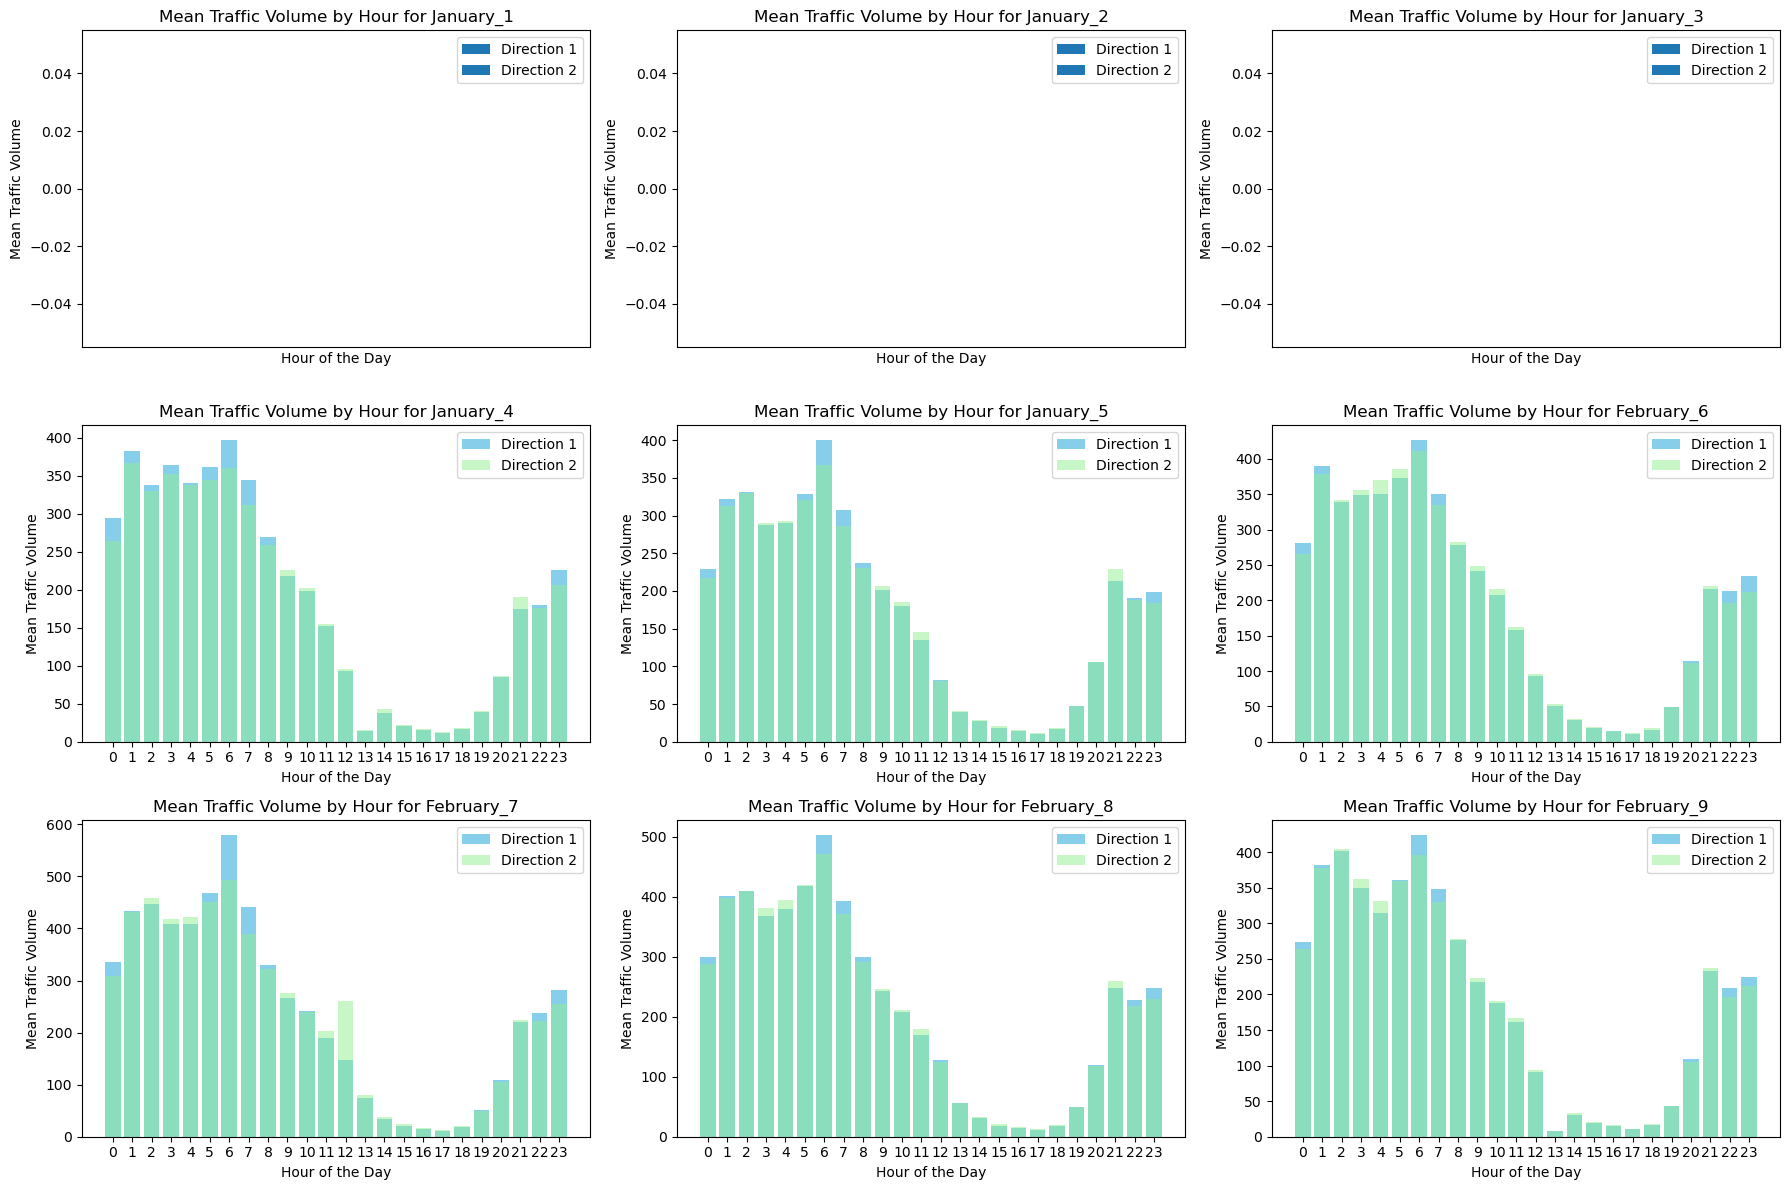

In [188]:
import matplotlib.pyplot as plt

# Define the grid size for the subplots
rows, cols = (3, 3)
fig, axs = plt.subplots(rows, cols, figsize=(18, 12))  

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Loop through each key in the DataFrame and plot the graphs
for i, (index, row) in enumerate(keys_df.iterrows()):
    week_key = row['Keys']
    
    # Convert 'timestamp' column to datetime format
    merged_dataframes[week_key]['timestamp'] = pd.to_datetime(merged_dataframes[week_key]['timestamp'])
    # Extract hour from timestamp
    merged_dataframes[week_key]['hour'] = merged_dataframes[week_key]['timestamp'].dt.hour
    # Group data by hour and calculate mean traffic volume for both directions
    hourly_traffic_dir1 = merged_dataframes[week_key].groupby('hour')['direction_1_x'].mean()
    hourly_traffic_dir2 = merged_dataframes[week_key].groupby('hour')['direction_2_x'].mean()

    # Check if we haven't exceeded the number of subplots
    if i < rows * cols:
        ax = axs[i]
        # Plot bar chart for direction 1 on the ith subplot
        ax.bar(hourly_traffic_dir1.index, hourly_traffic_dir1.values, color='skyblue', label='Direction 1')
        # Plot bar chart for direction 2 on the ith subplot
        ax.bar(hourly_traffic_dir2.index, hourly_traffic_dir2.values, color='lightgreen', alpha=0.5, label='Direction 2')
        ax.set_xlabel('Hour of the Day')
        ax.set_ylabel('Mean Traffic Volume')
        ax.set_title(f'Mean Traffic Volume by Hour for {week_key}')
        ax.legend()
        ax.set_xticks(hourly_traffic_dir1.index)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the dimensions of the grid of subplots (3x3)
rows, cols = 3, 3
fig, axs = plt.subplots(rows, cols, figsize=(18, 12))  # Adjust the figure size as needed

# Flatten the array of axes for easier iteration
axs = axs.flatten()

# Width of a bar
bar_width = 0.35

# Iterate over each week key and its corresponding axis in axs
for i, week_key in enumerate(merged_dataframes.keys()):
    # Check if we haven't exceeded the number of subplots
    if i < rows * cols:
        # Convert 'timestamp' column to datetime format
        merged_dataframes[week_key]['timestamp'] = pd.to_datetime(merged_dataframes[week_key]['timestamp'])

        # Extract hour from timestamp
        merged_dataframes[week_key]['hour'] = merged_dataframes[week_key]['timestamp'].dt.hour

        # Group data by hour and calculate mean traffic volume for both directions
        hourly_traffic_dir1 = merged_dataframes[week_key].groupby('hour')['direction_1_x'].mean()
        hourly_traffic_dir2 = merged_dataframes[week_key].groupby('hour')['direction_2_x'].mean()

        # Set the positions of the bars
        indexes = np.arange(len(hourly_traffic_dir1))
        
        # Plot bar chart for direction 1 on the ith subplot
        ax = axs[i]
        bars1 = ax.bar(indexes - bar_width/2, hourly_traffic_dir1.values, bar_width, color='skyblue', label='Direction 1')
        
        # Plot bar chart for direction 2 on the ith subplot
        bars2 = ax.bar(indexes + bar_width/2, hourly_traffic_dir2.values, bar_width, color='lightgreen', label='Direction 2')

        ax.set_xlabel('Hour of the Day')
        ax.set_ylabel('Mean Traffic Volume')
        ax.set_title(f'Mean Traffic Volume by Hour for {week_key}')
        ax.legend()
        ax.set_xticks(indexes)
        ax.set_xticklabels(indexes)  # Assuming hour labels are integers

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:

# Convert 'timestamp' column to datetime format
merged_dataframes[week_key]['timestamp'] = pd.to_datetime(merged_dataframes[week_key]['timestamp'])

# Extract hour from timestamp
merged_dataframes[week_key]['hour'] = merged_dataframes[week_key]['timestamp'].dt.hour

# Group data by hour and calculate mean traffic volume and mean rain
hourly_data = merged_dataframes[week_key].groupby('hour').agg({'total_of_directions': 'mean', 'rain': 'mean'})

# Plot bar chart
fig, ax1 = plt.subplots()

# Bar for traffic volume
color = 'tab:blue'
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Mean Traffic Volume', color=color)
ax1.bar(hourly_data.index, hourly_data['total_of_directions'], color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)

# Create another y-axis for rain
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Mean Rain', color=color)
ax2.plot(hourly_data.index, hourly_data['rain'], color=color, linestyle='-', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
plt.title(f'Mean Traffic Volume and Rain by Hour  [{week_key}]')
plt.xticks(range(24))
plt.show()


In [ ]:
week_key = 'January_4'

In [ ]:

# Convert 'timestamp' column to datetime format
merged_dataframes[week_key]['timestamp'] = pd.to_datetime(merged_dataframes[week_key]['timestamp'])

# Extract hour from timestamp
merged_dataframes[week_key]['hour'] = merged_dataframes[week_key]['timestamp'].dt.hour

# Group data by hour and calculate mean traffic volume and mean weather variables
hourly_data = merged_dataframes[week_key].groupby('hour').agg({
    'total_of_directions': 'mean', 
    'rain': 'mean', 
    'temperature_2m': 'mean', 
    'relative_humidity_2m': 'mean', 
    'precipitation': 'mean', 
    'showers': 'mean', 
    'uv_index': 'mean'
})

# Plot bar chart
fig, ax1 = plt.subplots()

# Bar for traffic volume
color = 'tab:blue'
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Mean Traffic Volume', color=color)
ax1.bar(hourly_data.index, hourly_data['total_of_directions'], color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)

# Create another y-axis for weather variables
ax2 = ax1.twinx()  

# Line plot for rain
color = 'tab:red'
ax2.set_ylabel('Weather Variables', color=color)
ax2.plot(hourly_data.index, hourly_data['rain'], color=color, linestyle='-', marker='o', label='Rain')
ax2.plot(hourly_data.index, hourly_data['temperature_2m'], color='green', linestyle='-', marker='o', label='Temperature')
ax2.plot(hourly_data.index, hourly_data['relative_humidity_2m'], color='orange', linestyle='-', marker='o', label='Relative Humidity')
ax2.plot(hourly_data.index, hourly_data['precipitation'], color='purple', linestyle='-', marker='o', label='Precipitation')
ax2.plot(hourly_data.index, hourly_data['showers'], color='brown', linestyle='-', marker='o', label='Showers')
ax2.plot(hourly_data.index, hourly_data['uv_index'], color='blue', linestyle='-', marker='o', label='UV Index')
ax2.tick_params(axis='y', labelcolor=color)

# Add legend
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.15,0.88))

# Show plot
plt.title(f'Mean Traffic Volume and Weather Variables by Hour [{week_key}]')
plt.xticks(range(24))
plt.show()


In [ ]:
# Extract hour from timestamp
merged_dataframes[week_key]['hour'] = merged_dataframes[week_key]['timestamp'].dt.hour

# Define precipitation measures
precipitation_measures = ['rain', 'precipitation', 'showers','uv_index','temperature_2m','relative_humidity_2m'] 

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over precipitation measures
for i, measure in enumerate(precipitation_measures):
    # Group data by hour and calculate mean for the current precipitation measure
    hourly_data = merged_dataframes[week_key].groupby('hour')[measure].mean()
    
    # Plot histogram of mean hourly precipitation
    axes[i].hist(hourly_data, bins=20, color='green', alpha=0.7)
    axes[i].set_xlabel(f'Mean Hourly {measure.capitalize()}')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of Mean Hourly {measure.capitalize()}')

# Hide empty subplots (if any)
for ax in axes[len(precipitation_measures):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


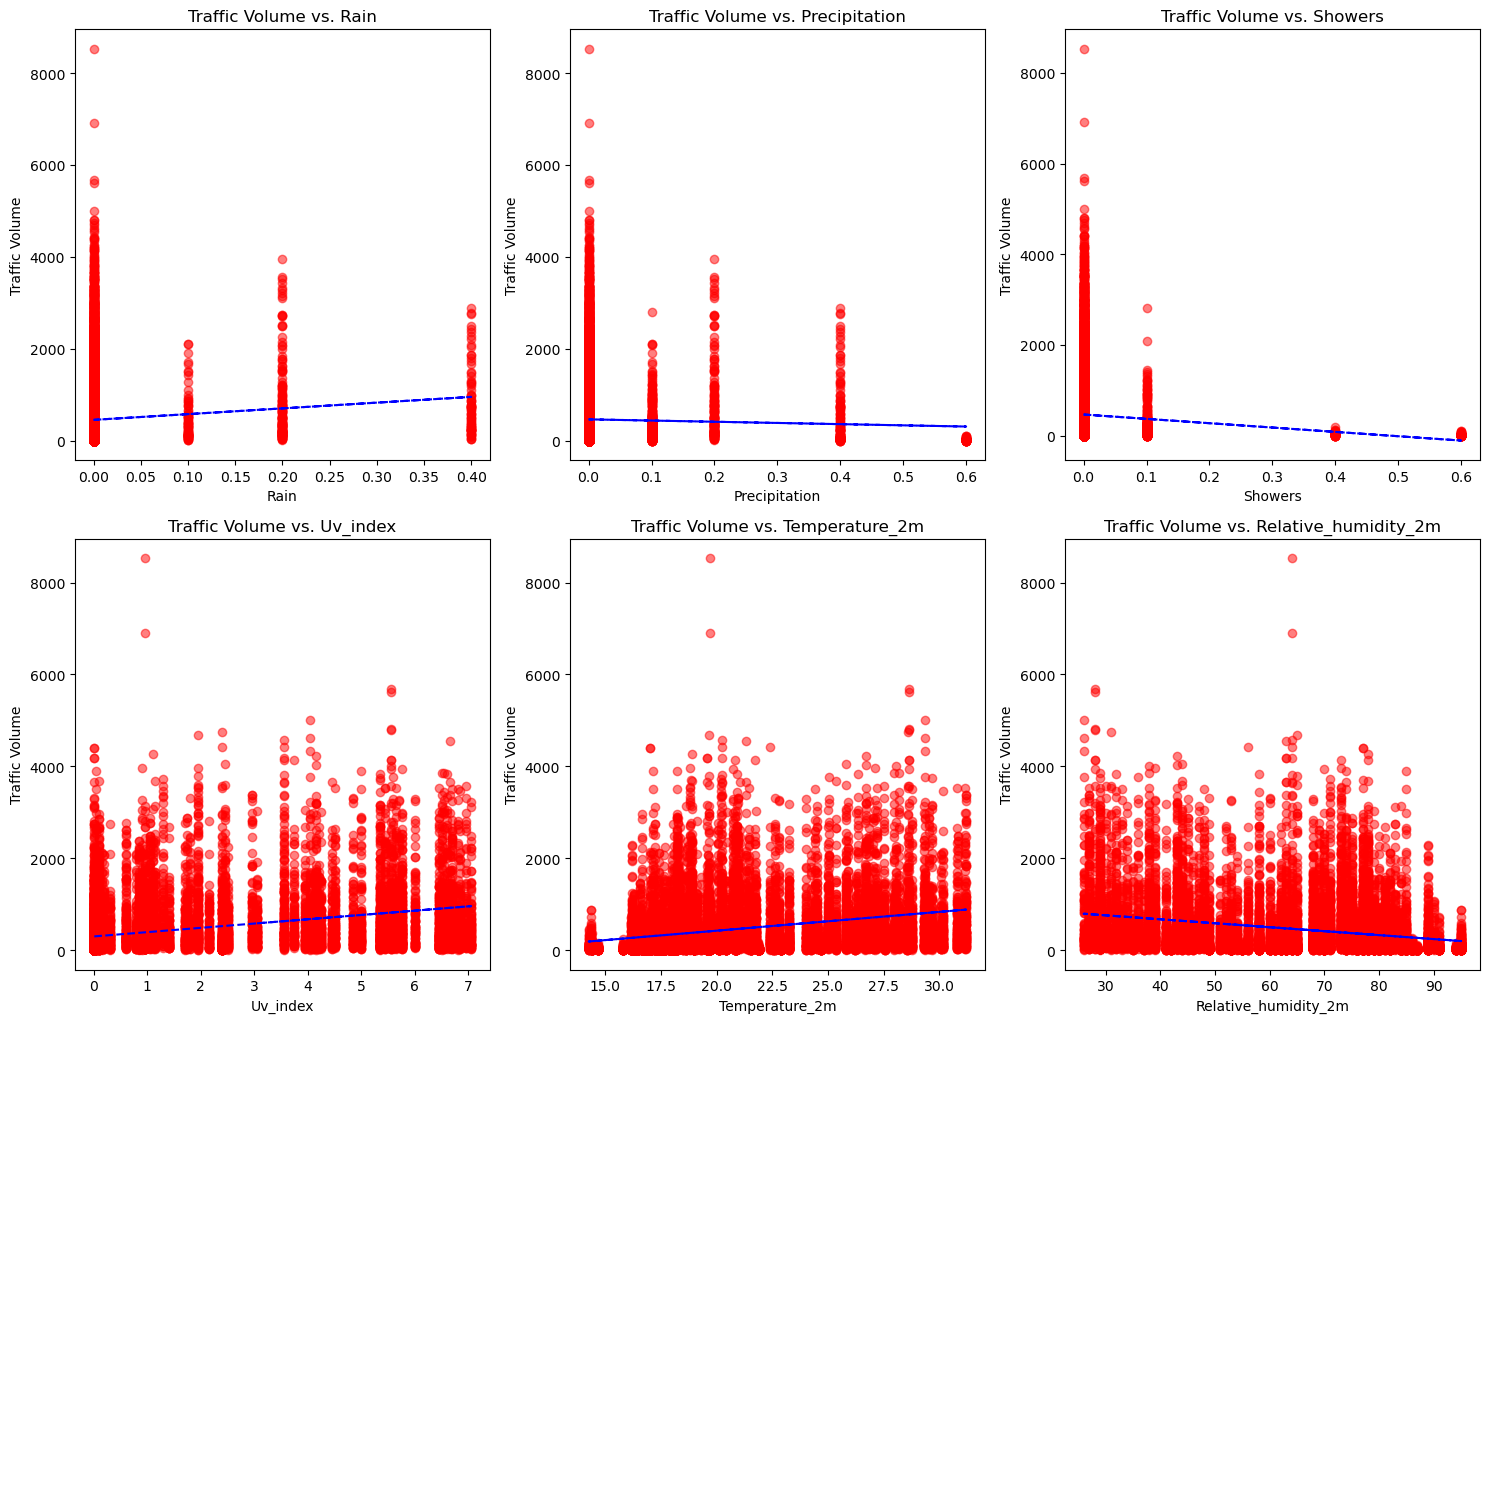

In [189]:

# Define function to calculate regression line
def plot_trend_line(x, y, ax):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line = slope * x + intercept
    ax.plot(x, line, color='blue', linestyle='--', label=f'Trend Line (R²={r_value**2:.2f})')

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over precipitation measures
for i, measure in enumerate(precipitation_measures):
    # Scatter plot of traffic volume vs. the current precipitation measure
    axes[i].scatter(merged_dataframes[week_key][measure], merged_dataframes[week_key]['total_of_directions'], color='red', alpha=0.5)
    axes[i].set_xlabel(measure.capitalize())  # Set x-axis label
    axes[i].set_ylabel('Traffic Volume')  # Set y-axis label
    axes[i].set_title(f'Traffic Volume vs. {measure.capitalize()}')  # Set title
    
    # Calculate and plot trend line
    plot_trend_line(merged_dataframes[week_key][measure], merged_dataframes[week_key]['total_of_directions'], axes[i])

# Hide empty subplots (if any)
for ax in axes[len(precipitation_measures):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
%history

In [ ]:

# # Drop rows with missing values
# analysis_df = analysis_df.dropna()

# # Select features and target
# X = analysis_df[['Average Temperature', 'Average Humidity', 'Total Precipitation']]
# y = analysis_df['Total Traffic Count']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize the linear regression model
# model = LinearRegression()

# # Train the model
# model.fit(X_train, y_train)

# # Make predictions on the testing set
# y_pred = model.predict(X_test)

# # Evaluate the model
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Mean Absolute Error:", mae)
# print("Mean Squared Error:", mse)
# print("R-squared:", r2)


## Function for correlation matrix

In [190]:
def check_correlations(df):
    # Focus on relevant columns for correlation
    relevant_columns = [
        'total_of_directions', 'temperature_2m', 'relative_humidity_2m', 
        'precipitation', 'rain', 'showers', 'weather_code', 'uv_index'
    ]
    # Compute the correlation matrix for the relevant columns
    corr_matrix = df[relevant_columns].corr()
    
    # Return the correlation matrix
    return corr_matrix


In [191]:

for week_key in merged_dataframes:
    print(f"Correlation for {week_key}:")
    corr_matrix = check_correlations(merged_dataframes[week_key])
    print(corr_matrix)
    print("\n")  # This will print a newline for better readability


Correlation for January_1:
                      total_of_directions  temperature_2m  \
total_of_directions                   NaN             NaN   
temperature_2m                        NaN             NaN   
relative_humidity_2m                  NaN             NaN   
precipitation                         NaN             NaN   
rain                                  NaN             NaN   
showers                               NaN             NaN   
weather_code                          NaN             NaN   
uv_index                              NaN             NaN   

                      relative_humidity_2m  precipitation  rain  showers  \
total_of_directions                    NaN            NaN   NaN      NaN   
temperature_2m                         NaN            NaN   NaN      NaN   
relative_humidity_2m                   NaN            NaN   NaN      NaN   
precipitation                          NaN            NaN   NaN      NaN   
rain                                   NaN 

# Combine all dfs into one

In [ ]:

combined_dataframes_list = []

for key in keys_df['Keys']:
    # Append each dataframe to the list
    combined_dataframes_list.append(merged_dataframes[week_key])

all_weeks_combined = pd.concat(combined_dataframes_list, axis=0)

# Reset the index of the combined dataframe
all_weeks_combined.reset_index(drop=True, inplace=True)
all_weeks_combined



# Normalizing the columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Display the data types of all columns
print(all_weeks_combined.dtypes)
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# List of columns to normalize
columns_to_normalize = ['total_of_directions', 'temperature_2m', 'relative_humidity_2m',
                        'precipitation', 'rain', 'showers', 'weather_code', 'uv_index']

# Fit the scaler on the data and transform it
all_weeks_combined[columns_to_normalize] = scaler.fit_transform(all_weeks_combined[columns_to_normalize])

# Print the scaled DataFrame
print(all_weeks_combined)


In [ ]:
unique_values = all_weeks_combined['direction_1_y'].unique()
print(unique_values)
unique_values2 = all_weeks_combined['direction_2_y'].unique()
print(unique_values2)

In [ ]:
# Display the data types of all columns
print(all_weeks_combined.dtypes)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)  # sparse=False ensures output is a numpy array

# Check if columns exist to avoid KeyError
if {'direction_1_y', 'direction_2_y'}.issubset(all_weeks_combined.columns):
    # Fit and transform the data
    encoded_data = encoder.fit_transform(all_weeks_combined[['direction_1_y', 'direction_2_y']])
    
    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(['direction_1_y', 'direction_2_y'])
    
    # Create a DataFrame with the encoded data and the generated feature names
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names)
    
    # Concatenate the encoded data back to the original DataFrame
    all_weeks_combined = pd.concat([all_weeks_combined.drop(['direction_1_y', 'direction_2_y'], axis=1), encoded_df], axis=1)
    print(all_weeks_combined.head())
else:
    print("Columns 'direction_1_y' or 'direction_2_y' are not found in the DataFrame.")


In [ ]:
print(all_weeks_combined.columns)  # This will list all column names in the DataFrame
all_weeks_combined

## Hash encording for the locationId column

In [ ]:
# from sklearn.feature_extraction import FeatureHasher

# # Initialize the hasher specifying the number of features 
# n_features = 10

# # Create the hasher instance with input_type set to default as it expects tuples
# hasher = FeatureHasher(n_features=n_features, input_type='pair')

# # Prepare the 'location_id' for hashing by converting each id into a tuple of (id, value)
# # The value '1' can be used since we're simply encoding the presence of each location_id
# hashed_input = [((str(loc_id), 1),) for loc_id in all_weeks_combined['location_id']]

# # Apply the hasher to the prepared input
# hashed_features = hasher.transform(hashed_input)

# # Convert the hashed features to a DataFrame for easier integration into your existing dataset
# hashed_features_df = pd.DataFrame(hashed_features.toarray(), columns=[f'hashed_{i}' for i in range(n_features)])

# # Concatenate the hashed features back into the main DataFrame
# all_weeks_combined = pd.concat([all_weeks_combined.drop('location_id', axis=1), hashed_features_df], axis=1)

# # Example to display the first few rows of the updated DataFrame
# print(all_weeks_combined.head())


In [ ]:
print(all_weeks_combined.columns)


## One Hot Encording for the locationID

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid multicollinearity

# # Select categorical columns
# categorical_features  = ['direction_1_y']

# # Apply OneHotEncoder to categorical columns
# encoded_features = encoder.fit_transform(all_weeks_combined[categorical_features])

# # Create DataFrame with encoded features and appropriate column names
# encoded_df = pd.DataFrame(encoded_features, 
#                           columns=encoder.get_feature_names_out(categorical_features))

# # Concatenate encoded features with the original DataFrame
# all_weeks_combined = pd.concat([all_weeks_combined, encoded_df], axis=1)

# # Drop original categorical columns
# all_weeks_combined.drop(categorical_features, axis=1, inplace=True)

# # Print the modified DataFrame
# print(all_weeks_combined)

In [192]:
# Calculate the correlation matrix for the numerical columns of interest
#selected_columns = all_weeks_combined.drop([ 'timestamp'], axis=1)
selected_columns = ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'rain', 'showers', 'uv_index','total_of_directions','direction_1_y_East',
       'direction_1_y_North', 'direction_2_y_South', 'direction_2_y_West']  
correlation_matrix = all_weeks_combined[selected_columns].corr()

# Display the correlation matrix
correlation_matrix


,temperature_2m,relative_humidity_2m,precipitation,rain,showers,uv_index,total_of_directions,direction_1_y_East,direction_1_y_North,direction_2_y_South,direction_2_y_West
temperature_2m,1.000000,-0.960927,-0.163358,-0.095958,-0.122363,0.620040,0.273122,0.004611,-0.004611,-0.004611,0.004611
relative_humidity_2m,-0.960927,1.000000,0.188462,0.096348,0.153547,-0.564346,-0.253373,-0.004213,0.004213,0.004213,-0.004213
precipitation,-0.163358,0.188462,1.000000,0.557055,0.810267,-0.117694,-0.027427,0.000087,-0.000087,-0.000087,0.000087
rain,-0.095958,0.096348,0.557055,1.000000,-0.021700,-0.051238,0.075871,0.000894,-0.000894,-0.000894,0.000894
showers,-0.122363,0.153547,0.810267,-0.021700,1.000000,-0.098830,-0.083045,-0.000684,0.000684,0.000684,-0.000684
uv_index,0.620040,-0.564346,-0.117694,-0.051238,-0.098830,1.000000,0.336381,0.001557,-0.001557,-0.001557,0.001557
total_of_directions,0.273122,-0.253373,-0.027427,0.075871,-0.083045,0.336381,1.000000,-0.108248,0.108248,0.108248,-0.108248
direction_1_y_East,0.004611,-0.004213,0.000087,0.000894,-0.000684,0.001557,-0.108248,1.000000,-1.000000,-1.000000,1.000000
direction_1_y_North,-0.004611,0.004213,-0.000087,-0.000894,0.000684,-0.001557,0.108248,-1.000000,1.000000,1.000000,-1.000000
direction_2_y_South,-0.004611,0.004213,-0.000087,-0.000894,0.000684,-0.001557,0.108248,-1.000000,1.000000,1.000000,-1.000000


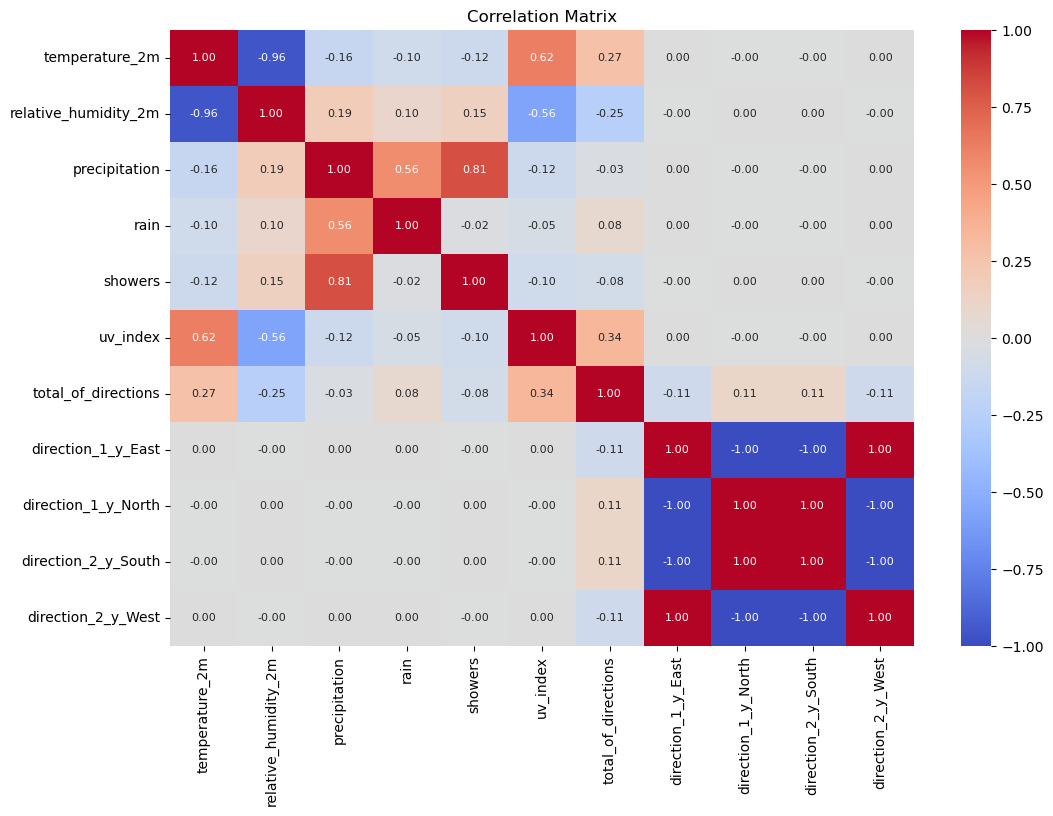

In [193]:


# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()


In [ ]:
def perform_regression(df):
    # Selecting the target variable and features
    #X = df[['temperature_2m', 'relative_humidity_2m', 'uv_index','showers','rain']]  
    # Mean Squared Error: 0.005115399601514251
    # R^2 Score: 0.1291088971360574

    
    X = df[['temperature_2m', 'relative_humidity_2m', 'uv_index','showers','rain','direction_1_y_East','direction_1_y_North', 'direction_2_y_South', 'direction_2_y_West']]  
    y = df['total_of_directions']

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Creating a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Evaluating the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

# Call the function with your DataFrame
perform_regression(all_weeks_combined)  # Adjust parameters as needed based on the correlation results


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

def perform_advanced_regression(all_weeks_combined):
    # Selecting the target variable and features
    X = all_weeks_combined[['temperature_2m', 'relative_humidity_2m', 'uv_index', 'showers', 'rain','direction_1_y_East','direction_1_y_North', 'direction_2_y_South', 'direction_2_y_West']]
    y = all_weeks_combined['total_of_directions']

    # Adding polynomial features
    poly_model = make_pipeline(PolynomialFeatures(2), Ridge())

    # Cross-validation
    scores = cross_val_score(poly_model, X, y, cv=5, scoring='r2')
    print(f"Cross-validated R^2 scores: {scores}")
    print(f"Average R^2 score: {scores.mean()}")

# Call the function with your DataFrame
perform_advanced_regression(all_weeks_combined)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def perform_random_forest_regression(df):
    X = all_weeks_combined[['temperature_2m', 'relative_humidity_2m', 'uv_index', 'showers', 'rain','direction_1_y_East','direction_1_y_North', 'direction_2_y_South', 'direction_2_y_West']]
    y = all_weeks_combined['total_of_directions']
    
    # Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Fitting the model
    rf_model.fit(X, y)
    
    # Cross-validation
    scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
    print(f"Cross-validated R^2 scores: {scores}")
    print(f"Average R^2 score: {scores.mean()}")

    # Feature importance
    importances = rf_model.feature_importances_
    feature_names = X.columns
    importance_dict = dict(zip(feature_names, importances))
    print("Feature importances:", importance_dict)

# Call the function
perform_random_forest_regression(all_weeks_combined)


In [ ]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import cross_val_score

# def perform_xgboost_regression(df):
#     X = dfall_weeks_combined[['temperature_2m', 'relative_humidity_2m', 'uv_index', 'showers', 'rain']]
#     y = all_weeks_combined['total_of_directions']

#     # XGBoost model
#     xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    
#     # Fitting the model
#     xgb_model.fit(X, y)
    
#     # Cross-validation
#     scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
#     print(f"Cross-validated R^2 scores: {scores}")
#     print(f"Average R^2 score: {scores.mean()}")

#     # Feature importance
#     importances = xgb_model.feature_importances_
#     feature_names = X.columns
#     importance_dict = dict(zip(feature_names, importances))
#     print("Feature importances:", importance_dict)

# # Call the function
# perform_xgboost_regression(all_weeks_combined)


# Footpath Steepness

In [185]:
# Define the HTML code for the map
html_code = """
<iframe src="https://data.melbourne.vic.gov.au/explore/embed/dataset/footpath-steepness/map/?location=16,-37.81284,144.95249&basemap=mbs-7a7333" width="1100" height="600" frameborder="0"></iframe>
"""

# Display the map in the notebook
HTML(html_code)


In [ ]:
print(footpath_steepness.dtypes)

In [ ]:
footpath_steepness

In [ ]:
import json
from shapely.geometry import shape
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON into a GeoDataFrame
gdf = gpd.read_file('footpath-steepness.geojson')

# Check the first few records to understand what the data looks like
print(gdf.head())

# Perform a quick plot to visualize
gdf.plot()

# Show the plot
plt.show()


In [ ]:
gdf

In [ ]:
columns_to_check = ['grade1in', 'gradepc', 'deltaz', 'rlmax', 'rlmin', 'distance']

# Drop rows where all the specified columns are missing
gdf_cleaned = gdf.dropna(subset=columns_to_check, how='all')

# Display the first few rows of the cleaned DataFrame to verify the operation
gdf_cleaned

In [ ]:

descriptive_stats = gdf_cleaned[['grade1in', 'gradepc']].describe()

# Identifying missing values
missing_values = gdf_cleaned[['grade1in', 'gradepc']].isnull().sum()

# Outputting the results
print(descriptive_stats)
print('-----------------')
print(missing_values)


In [ ]:
print(gdf_cleaned.dtypes)

In [ ]:
import matplotlib.pyplot as plt

# Histogram for grade1in
plt.figure(figsize=(5, 3))
plt.hist(gdf_cleaned['grade1in'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Grade Inclination (1 in X)')
plt.xlabel('Grade Inclination (1 in X)')
plt.ylabel('Frequency')
plt.show()

# Histogram for gradepc
plt.figure(figsize=(5, 3))
plt.hist(gdf_cleaned['gradepc'].dropna(), bins=50, color='green', edgecolor='black')
plt.title('Distribution of Grade Percentage (%)')
plt.xlabel('Grade Percentage (%)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
plt.figure(figsize=(5, 3))
plt.scatter(gdf_cleaned['grade1in'], gdf_cleaned['gradepc'], alpha=0.5)
plt.title('Grade Percentage vs Grade Inclination')
plt.xlabel('Grade Inclination (1 in X)')
plt.ylabel('Grade Percentage (%)')
plt.show()


## Steepness by grade percentage

In [ ]:
import geopandas as gpd
# Initialize the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the data
gdf_cleaned.plot(column='gradepc', scheme='quantiles', ax=ax, legend=True,
                 legend_kwds={'title': "Steepness by Grade Percentage (%)", 'loc': 'lower right'})

# Set the axis off
ax.set_axis_off()

# Show the plot
plt.show()


In [195]:
import pandas as pd
from scipy.spatial.distance import cdist

# Assuming gdf_cleaned is your GeoDataFrame that has been cleaned up

# Sample 100 rows
subset_gdf = gdf_cleaned.sample(n=100, random_state=1)

# Extract coordinates into separate columns
subset_gdf['lat'] = subset_gdf['geo_point_2d'].apply(lambda x: x['lat'])
subset_gdf['lon'] = subset_gdf['geo_point_2d'].apply(lambda x: x['lon'])

# Prepare the coordinates array
coords = subset_gdf[['lat', 'lon']]

# Calculate the Euclidean distance matrix
dist_matrix = cdist(coords, coords, metric='euclidean')

# Print the distance matrix
print(dist_matrix)


[[0.         0.01556568 0.05658006 ... 0.03507755 0.04588261 0.01289302]
 [0.01556568 0.         0.06160849 ... 0.03017014 0.05290615 0.0257397 ]
 [0.05658006 0.06160849 0.         ... 0.03881605 0.01233092 0.06549711]
 ...
 [0.03507755 0.03017014 0.03881605 ... 0.         0.03524582 0.04787274]
 [0.04588261 0.05290615 0.01233092 ... 0.03524582 0.         0.0538872 ]
 [0.01289302 0.0257397  0.06549711 ... 0.04787274 0.0538872  0.        ]]


In [196]:
# Sort locations by gradepc
priority_indices = np.argsort(-subset_gdf['gradepc'])

In [197]:
sorted_gdf = subset_gdf.iloc[priority_indices]
sorted_gdf

,geo_point_2d,geo_shape,grade1in,gradepc,segside,statusid,asset_type,deltaz,streetid,mccid_int,mcc_id,address,rlmax,rlmin,distance,geometry,lat,lon
17527,"{'lon': 144.91086414619127, 'lat': -37.8011080...",None,1.2,86.78,East,2,Road Footway,5.87,1074.0,21685.0,1386033,Sims Street between Dynon Road and Footscray Road,7.62,1.75,6.76,"MULTIPOLYGON (((144.91084 -37.80109, 144.91093...",-37.801108,144.910864
16567,"{'lon': 144.96823402538334, 'lat': -37.8187452...",None,2.3,43.47,East,2,Road Footway,2.59,1114.0,22195.0,1467298,Swanston Street between Princes Bridge and Fli...,3.96,1.37,5.96,"MULTIPOLYGON (((144.96823 -37.81875, 144.96823...",-37.818745,144.968234
26375,"{'lon': 144.92829613783093, 'lat': -37.8089748...",None,7.0,14.34,South,1,Road Footway,0.41,640.0,22440.0,1386371,Footscray Road between Appleton Dock Road and ...,2.59,2.18,2.86,"MULTIPOLYGON (((144.92829 -37.80898, 144.92830...",-37.808975,144.928296
31740,"{'lon': 144.95201376006156, 'lat': -37.8198337...",None,7.2,13.94,East,1,Road Footway,6.13,117786.0,22555.0,1434736,Wurundjeri Way between Bourke Street and Flind...,18.52,12.39,43.98,"MULTIPOLYGON (((144.95182 -37.81989, 144.95182...",-37.819834,144.952014
14597,"{'lon': 144.93330624686234, 'lat': -37.7913512...",None,7.9,12.68,East,2,Road Footway,0.39,119630.0,22984.0,1389668,Collett Street between Smith Street and Parson...,6.10,5.71,3.08,"MULTIPOLYGON (((144.93330 -37.79146, 144.93328...",-37.791351,144.933306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1560,"{'lon': 144.9729611138122, 'lat': -37.80821277...",None,NaN,0.00,West,2,Road Footway,0.00,931.0,21554.0,1467372,Nicholson Street between Albert Street and Vic...,38.51,38.51,0.00,"MULTIPOLYGON (((144.97296 -37.80821, 144.97296...",-37.808213,144.972961
31938,"{'lon': 144.9435791265556, 'lat': -37.81335629...",None,NaN,0.00,West,2,Road Footway,0.00,117766.0,22835.0,1556154,Harbour Esplanade between La Trobe Street and ...,2.35,2.35,0.00,"MULTIPOLYGON (((144.94358 -37.81336, 144.94358...",-37.813356,144.943579
2091,"{'lon': 144.9689547855373, 'lat': -37.79919917...",None,NaN,0.00,None,3,Road Footway,0.00,915.0,20707.0,1384447,Moton Place between Drummond Street and Rathdo...,40.29,40.29,0.00,"MULTIPOLYGON (((144.96887 -37.79918, 144.96904...",-37.799199,144.968955
17766,"{'lon': 144.92213049714536, 'lat': -37.7972238...",None,NaN,0.00,None,2,Road Footway,0.00,0.0,21837.0,1389429,Intersection of Kensington Road and Mercantile...,1.56,1.56,0.00,"MULTIPOLYGON (((144.92209 -37.79724, 144.92214...",-37.797224,144.922130


In [198]:
if isinstance(priority_indices, pd.Series):
    priority_indices = priority_indices.values

# Initialize route list with the starting point (using the first location as the start)
route = [priority_indices[0]]

# Iterate to build the route
for _ in range(1, len(priority_indices)):
    last_visited = route[-1]
    # Retrieve distances to the last visited location from the distance matrix
    distances_to_last_visited = dist_matrix[last_visited].copy()

    # Set distances to already visited locations to infinity
    distances_to_last_visited[route] = np.inf

    # Find the index of the minimum distance that's not infinity (i.e., unvisited)
    next_stop = np.argmin(distances_to_last_visited)
    
    # Append the next stop to the route
    route.append(next_stop)

# Convert route indices back to original DataFrame indices if necessary
route_indices = priority_indices[route]

# Optionally, display the sorted route by actual DataFrame indices
sorted_route_gdf = sorted_gdf.iloc[route_indices]
print(sorted_route_gdf)

                                            geo_point_2d geo_shape  grade1in  \
23842  {'lon': 144.942272014472, 'lat': -37.775945269...      None      13.2   
17734  {'lon': 144.9435384634853, 'lat': -37.82430163...      None      79.8   
16567  {'lon': 144.96823402538334, 'lat': -37.8187452...      None       2.3   
22326  {'lon': 144.96332038413092, 'lat': -37.8217955...      None     127.6   
10839  {'lon': 144.94134805676808, 'lat': -37.7891239...      None      31.7   
...                                                  ...       ...       ...   
27538  {'lon': 144.92678628925003, 'lat': -37.7955737...      None      25.5   
23403  {'lon': 144.96675399846313, 'lat': -37.8259981...      None     292.3   
33541  {'lon': 144.92991476220553, 'lat': -37.7905600...      None     205.1   
32905  {'lon': 144.9066350463969, 'lat': -37.78623345...      None      78.5   
28383  {'lon': 144.93689738740395, 'lat': -37.7966109...      None      86.3   

       gradepc segside statusid    asse

In [199]:
map_center = [sorted_route_gdf['lat'].mean(), sorted_route_gdf['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=14)
m

In [200]:
import folium

# Assuming 'm' is already created and 'route' is defined as indices from 'new_DF'
for idx in route:
    # Access the location data by DataFrame index
    lat = sorted_route_gdf.iloc[idx]['lat']
    lon = sorted_route_gdf.iloc[idx]['lon']
    gradepc = sorted_route_gdf.iloc[idx]['gradepc']  # Assuming gradepc is directly a percentage value

    # Create a marker for each location in the route
    folium.Marker(
        location=[lat, lon],
        popup=f"Grade PC: {gradepc:.2f}%",  # Format grade percent to 2 decimal places
        icon=folium.Icon(color="blue", icon="info-sign")  # Blue icon with info sign
    ).add_to(m)

# If running in a Jupyter environment, display the map
m


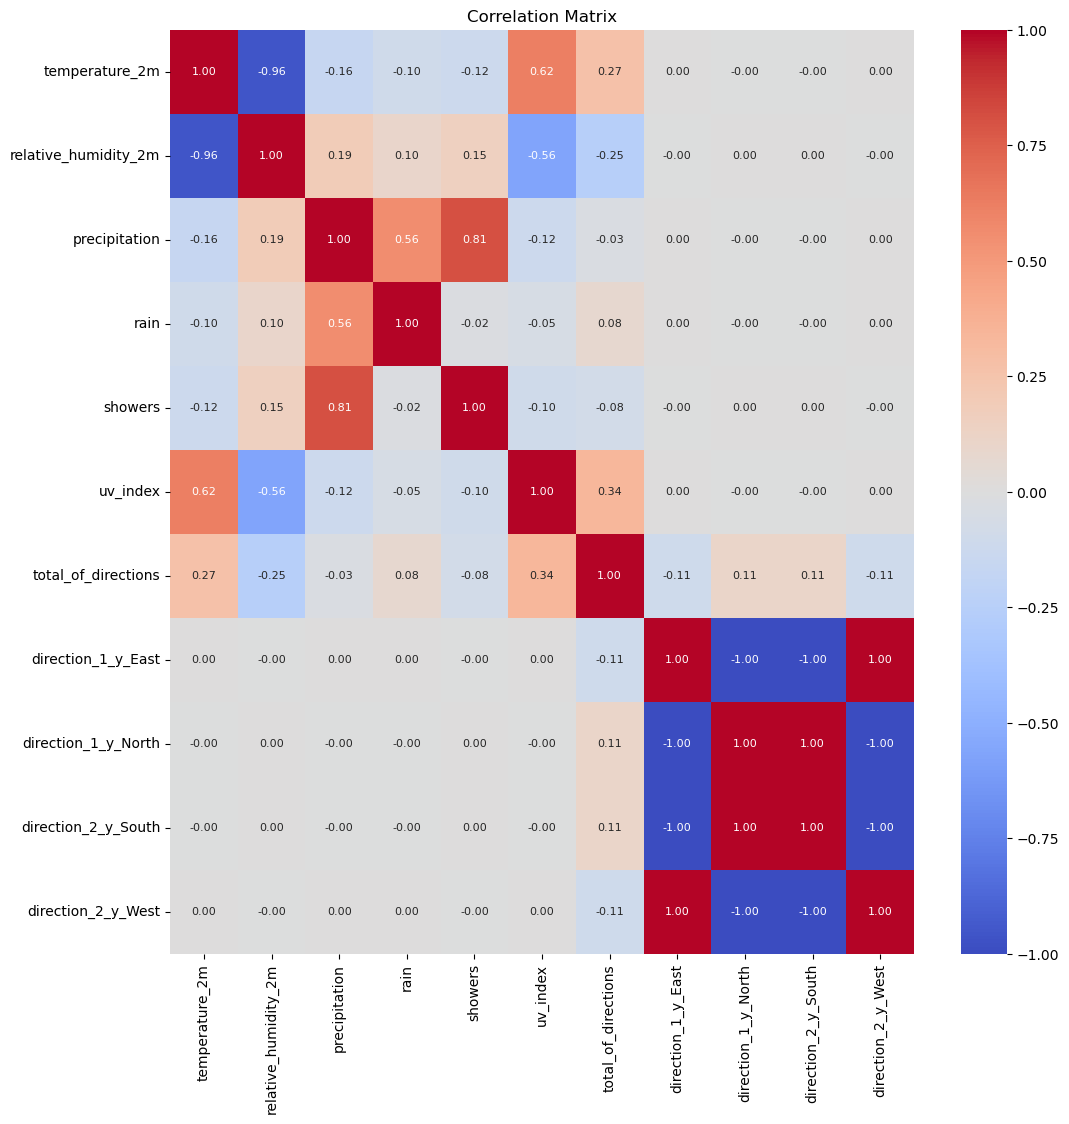

In [201]:


# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()


In [202]:
# Display route as lines
for i in range(len(route)-1):
    folium.PolyLine([sorted_route_gdf.iloc[route[i]][['lat', 'lon']].values,
                     sorted_route_gdf.iloc[route[i+1]][['lat', 'lon']].values],
                    color="red").add_to(m)

Best_Route_Map=m
Best_Route_Map

In [ ]:
gdf_cleaned

In [ ]:
traffic_gdf

## Spatial Join with Pedestrian Data

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Convert your DataFrame to a GeoDataFrame
traffic_gdf = gpd.GeoDataFrame(
    all_weeks_combined,
    geometry=gpd.points_from_xy(all_weeks_combined.longitude, all_weeks_combined.latitude),
    crs="EPSG:4326"  # Assuming your lat/long is in WGS84
)
# Perform a spatial join using the `predicate` parameter
joined_gdf = gpd.sjoin(traffic_gdf, gdf_cleaned, how="inner", predicate="intersects")

# Analyze the joined GeoDataFrame
# For example, you might summarize pedestrian counts by path steepness or asset type
summary_stats = joined_gdf.groupby('asset_type')['total_of_directions'].describe()
summary_stats

In [ ]:
joined_gdf.columns




In [ ]:
# Categorize steepness to make it more understandable
def categorize_steepness(grade_pc):
    if grade_pc < 2:
        return 'Gentle'
    elif grade_pc < 5:
        return 'Moderate'
    else:
        return 'Steep'

# Apply the categorization
joined_gdf['steepness_category'] = joined_gdf['gradepc'].apply(categorize_steepness)

# Sort the DataFrame by steepness percentage for recommendation
sorted_gdf = joined_gdf.sort_values(by='gradepc')

# If you need to filter out paths based on user preference for less steep paths:
less_steep_paths = sorted_gdf[sorted_gdf['steepness_category'] == 'Gentle']

# Display or utilize the sorted or filtered DataFrame as needed
print(sorted_gdf[['location_id', 'address', 'gradepc', 'steepness_category']])


In [ ]:
import numpy as np
import pandas as pd

# Assuming 'joined_gdf' is already loaded with the 'gradepc' column

# Select a subset of the DataFrame to reduce the size of the distance matrix
subset_gdf = joined_gdf.sample(n=100, random_state=1)  # Adjust the number to suit your needs or system capacity

# Normalize the steepness percentage for the subset
max_steepness = subset_gdf['gradepc'].max()
subset_gdf['normalized_steepness'] = subset_gdf['gradepc'] / max_steepness

# Create a distance matrix based on steepness for the subset
num_paths = len(subset_gdf)
distance_matrix = np.zeros((num_paths, num_paths))

for i in range(num_paths):
    for j in range(num_paths):
        # Calculate the absolute difference in normalized steepness between paths
        distance_matrix[i][j] = abs(subset_gdf.iloc[i]['normalized_steepness'] - subset_gdf.iloc[j]['normalized_steepness'])

# Optionally, print the matrix or parts of it to inspect
print(distance_matrix)


In [ ]:
subset_gdf['centroid'] = subset_gdf['geometry'].centroid
print(subset_gdf['centroid'].isnull().sum())
subset_gdf

In [ ]:
subset_gdf['location_id']

In [ ]:
import matplotlib.pyplot as plt

# Plotting the distribution of gradepc values
plt.hist(subset_gdf['gradepc'], bins=20)
plt.title('Distribution of Grade Percentages')
plt.xlabel('Grade Percentage')
plt.ylabel('Frequency')
plt.show()

# Also, check unique values
print("Unique steepness percentages:", subset_gdf['gradepc'].unique())


In [ ]:
# import networkx as nx

# # Initialize a graph
# G = nx.Graph()

# # Add edges to the graph from the distance matrix
# for i in range(num_paths):
#     for j in range(i+1, num_paths):  # to avoid duplication since the matrix is symmetric
#         # Assuming i and j are indices of the endpoints of the paths
#         weight = distance_matrix[i][j]
#         if weight > 0:  # if there is a significant difference in steepness
#             G.add_edge(i, j, weight=weight)


In [ ]:

threshold_distance = 50 
# Populate the graph with nodes for each path
for idx, row in subset_gdf.iterrows():
    G.add_node(idx, centroid=row['centroid'])

# Populate the graph with edges based on centroid proximity
for idx1, row1 in subset_gdf.iterrows():
    for idx2, row2 in subset_gdf.iterrows():
        if idx1 != idx2:
            # Calculate the distance between centroids
            distance = row1['centroid'].distance(row2['centroid'])
            if distance <= threshold_distance:
                # Add an edge if paths are close enough, with the weight based on steepness
                G.add_edge(idx1, idx2, weight=abs(row1['normalized_steepness'] - row2['normalized_steepness']))

In [ ]:
# Dijkstra's algorithm to find the least steep path
start_node = 0  # or the index of your starting path
end_node = 99   # or the index of your destination path

# Check first if there is a path
if nx.has_path(G, start_node, end_node):
    path = nx.dijkstra_path(G, source=start_node, target=end_node, weight='weight')
    print("Path:", path)
else:
    print("No path found between the start and end nodes.")



In [ ]:
# Check number of edges and nodes in the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Verify connectivity between nodes
if nx.has_path(G, start_node, end_node):
    print("There is a path between the start and end nodes.")
else:
    print("No path exists between the start and end nodes within the current graph structure.")


In [ ]:
# This requires matplotlib to be installed
import matplotlib.pyplot as plt

nx.draw(G, with_labels=True)
plt.show()


In [ ]:
# Reset the index of the subset_gdf to ensure it starts at 0
subset_gdf.reset_index(drop=True, inplace=True)

# Example of extracting coordinates
path_coords = []
for node in path:  # 'path' is the list of nodes from the pathfinding algorithm
    geometry = subset_gdf.loc[node, 'geometry']  # Replace 'geometry' with the appropriate column if different
    if geometry.type == 'Point':
        path_coords.append((geometry.x, geometry.y))
    else:
        # If the geometry is a line, you can take the centroid or start/end points
        path_coords.append((geometry.centroid.x, geometry.centroid.y))


In [ ]:
import folium

# Create a map object centered around the midpoint of your path
midpoint = path_coords[len(path_coords) // 2]
m = folium.Map(location=midpoint, zoom_start=14)

# Add the path as a PolyLine
folium.PolyLine(path_coords, color='blue', weight=2.5, opacity=1).add_to(m)

# Optionally, add markers for the start and end points
folium.Marker(
    location=path_coords[0],
    popup='Start',
    icon=folium.Icon(color='green')
).add_to(m)

folium.Marker(
    location=path_coords[-1],
    popup='End',
    icon=folium.Icon(color='red')
).add_to(m)

# Show the map
m


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming joined_gdf is your joined GeoDataFrame and it has a geometry column
fig, ax = plt.subplots(figsize=(15, 15))  # Adjust the size as needed

joined_gdf.plot(column='total_of_directions', ax=ax, legend=True,
                legend_kwds={'label': "Total Directions",
                             'orientation': "horizontal"})

plt.show()


In [ ]:
# Save to GeoJSON
joined_gdf.to_file("joined_gdf.geojson", driver='GeoJSON')


In [ ]:
import folium
import geopandas as gpd

# Assuming 'gdf_cleaned' is your GeoDataFrame with the 'gradepc' column

# Convert the GeoDataFrame to GeoJSON
gdf_geojson = gdf_cleaned.to_json()

# Create a Folium map object. Set the initial location to your data's centroid.
# Replace 'your_latitude' and 'your_longitude' with the actual coordinates.
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=13)

folium.GeoJson(
    gdf_geojson,
    name='Steepness by Grade Percentage',
    style_function=lambda feature: {
        'fillColor': 'green' if feature['properties']['gradepc'] < 5 
            else 'yellow' if 5 <= feature['properties']['gradepc'] < 10 
            else 'orange' if 10 <= feature['properties']['gradepc'] < 15 
            else 'red' if 15 <= feature['properties']['gradepc'] < 20 
            else 'darkred',
                      
        
       
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(fields=['gradepc'], aliases=['Steepness %: '])
).add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Add a layer control panel to the map.
folium.LayerControl().add_to(m)

# Display the map
m


In [ ]:
gdf_cleaned['geometry']

# creating a network graph where each polygon is connected to its neighbors.

### finding centroids of the polygons

In [ ]:
gdf_cleaned['centroid'] = gdf_cleaned['geometry'].centroid
print(gdf_cleaned['centroid'].isnull().sum())


In [ ]:
gdf_cleaned

In [ ]:
import networkx as nx

# Initialize graph
G = nx.Graph()

# Add nodes to the graph from the centroid points
for index, row in gdf_cleaned.iterrows():
    if row['centroid'] is not None:
        G.add_node(row['centroid'])


# Assume we have a function that calculates the weight between two nodes based on steepness
def calculate_weight(node1, node2):
    distance = node1.distance(node2)
    if distance != 0:
        return 1 / distance  # Example weight calculation
    else:
        return float('inf')  # Prevent division by zero if nodes are at the same position



In [ ]:
# For example, create edges for centroids that are within a certain distance
some_distance_threshold = 100  # example value; adjust based on your data's scale

from itertools import combinations

for node1, node2 in combinations(G.nodes, 2):
    if node1.distance(node2) < some_distance_threshold:
        G.add_edge(node1, node2, weight=calculate_weight(node1, node2))


In [ ]:
# Find shortest path in the graph based on weights
shortest_path = nx.shortest_path(G, source=start_node, target=end_node, weight='weight')


### Calculating distance from one polygon to all others

In [ ]:
from shapely.geometry import Point

# Example: Calculating distance from one polygon to all others
reference_point = gdf_cleaned.iloc[0]['centroid']  # For example, use the first polygon's centroid

# Calculate distances from the reference point to all other centroids
gdf_cleaned['distance_to_reference'] = gdf_cleaned['centroid'].apply(lambda x: reference_point.distance(x))
gdf_cleaned['distance_to_reference']

# Sort by distance to find the closest polygons
closest_polygons = gdf_cleaned.sort_values(by='distance_to_reference')

# Get the closest polygon (excluding the reference polygon itself if included)
closest_polygon = closest_polygons.iloc[1]  # .iloc[1] skips the first entry if it's the reference itself


In [ ]:
# Ensure the spatial index is properly created for the GeoDataFrame
gdf_cleaned.sindex

# Define your reference point using longitude and latitude
reference_point = Point(144.966094, -37.814141)  # Replace with your specific point

# Use the spatial index to find the nearest polygon to the reference point
possible_matches_index = list(gdf_cleaned.sindex.nearest(reference_point, num_results=1))
closest_polygon = gdf_cleaned.iloc[possible_matches_index[0]]

# Print the closest polygon
print(closest_polygon)

In [ ]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import Polygon, LineString
from itertools import combinations



# Initiate a Graph
G = nx.Graph()

# Extract edges and add to the graph
for poly1, poly2 in combinations(gdf_cleaned.geometry, 2):
    if poly1.intersects(poly2):
        # Find the boundary/line that intersects
        shared_boundary = poly1.intersection(poly2)
        if isinstance(shared_boundary, LineString):
            start, end = list(shared_boundary.coords)
            G.add_edge(start, end, weight=calculate_weight(shared_boundary))

# The calculate_weight function is hypothetical here and should be defined according to your criteria
# For example:
def calculate_weight(line):
    # Implement the logic for calculating weight
    # This could involve querying a separate DataFrame that has steepness information
    # and calculating an average steepness for the shared boundary.
    return weight


In [ ]:
#traffic_gdf, gdf_cleaned

In [ ]:
gdf['geometry']

# Suggesting the best route

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



# Clean and prepare data
footpath_steepness[['latitude', 'longitude']] = footpath_steepness['geo_point_2d'].str.split(',', expand=True).astype(float)
footpath_steepness.drop(columns=['geo_point_2d'], inplace=True)

# Fill missing values or drop them
footpath_steepness.fillna({'grade1in': footpath_steepness['grade1in'].mean(), 'gradepc': footpath_steepness['gradepc'].mean(), 'distance': footpath_steepness['distance'].mean()}, inplace=True)

# Features for clustering
features =footpath_steepness[['latitude', 'longitude', 'grade1in', 'gradepc']]

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
footpath_steepness['cluster'] = kmeans.fit_predict(features_scaled)

# Analyze clusters
for i in range(3):
    cluster = df[df['cluster'] == i]
    print(f"Cluster {i}:")
    print(cluster.describe())

# Assuming you have a location, find the nearest cluster
def find_nearest_cluster(latitude, longitude):
    location = scaler.transform([[latitude, longitude, 0, 0]])  # Assuming average steepness for simplicity
    cluster_label = kmeans.predict(location)[0]
    return df[df['cluster'] == cluster_label]

# Example usage
current_location = (-37.80, 144.92)
nearest_paths = find_nearest_cluster(*current_location)
print("Recommended Pathways:", nearest_paths)


In [ ]:
def plot_relationships(df):
    sns.pairplot(df, vars=['total_of_directions', 'temperature_2m', 'relative_humidity_2m', 'uv_index'],
                 kind='scatter', diag_kind='kde')
    plt.show()

# Call the function with your DataFrame
plot_relationships(all_weeks_combined)


In [ ]:
def plot_time_series(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df['timestamp'], df['total_of_directions'], label='Pedestrian Count')
    plt.plot(df['timestamp'], df['temperature_2m'], label='Temperature', secondary_y=True)
    plt.title('Time Series of Pedestrian Count and Temperature')
    plt.xlabel('Timestamp')
    plt.ylabel('Pedestrian Count')
    plt.right_ylabel('Temperature (°C)')
    plt.legend()
    plt.show()

# Call the function to plot
plot_time_series(all_weeks_combined)



#Dinuk Edited
_**DELETE BEFORE PUBLISHING**_

_This is a template also containing the style guide for use cases. The styling uses the use-case css when uploaded to the website, which will not be visible on your local machine._

_Change any text marked with {} and delete any cells marked DELETE_

***

In [ ]:
# DELETE BEFORE PUBLISHING
# This is just here so you can preview the styling on your local machine

from IPython.core.display import HTML
HTML("""
<style>
.usecase-title, .usecase-duration, .usecase-section-header {
    padding-left: 15px;
    padding-bottom: 10px;
    padding-top: 10px;
    padding-right: 15px;
    background-color: #0f9295;
    color: #fff;
}

.usecase-title {
    font-size: 1.7em;
    font-weight: bold;
}

.usecase-authors, .usecase-level, .usecase-skill {
    padding-left: 15px;
    padding-bottom: 7px;
    padding-top: 7px;
    background-color: #baeaeb;
    font-size: 1.4em;
    color: #121212;
}

.usecase-level-skill  {
    display: flex;
}

.usecase-level, .usecase-skill {
    width: 50%;
}

.usecase-duration, .usecase-skill {
    text-align: right;
    padding-right: 15px;
    padding-bottom: 8px;
    font-size: 1.4em;
}

.usecase-section-header {
    font-weight: bold;
    font-size: 1.5em;
}

.usecase-subsection-header, .usecase-subsection-blurb {
    font-weight: bold;
    font-size: 1.2em;
    color: #121212;
}

.usecase-subsection-blurb {
    font-size: 1em;
    font-style: italic;
}
</style>
""")

<div class="usecase-title">{Use Case Name}</div>

<div class="usecase-authors"><b>Authored by: </b> {Author/s}</div>

<div class="usecase-duration"><b>Duration:</b> {90} mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>{Intermediate}</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>{Python, and add any more skills needed}</div>
</div>

<div class="usecase-section-header">Scenario</div>

{Using User Story format, write a description of the problem you are trying to solve for this use case.}

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- {list the skills demonstrated in your use case}

<div class="usecase-section-header">{Heading for introduction or background relating to problem}</div>

{Write your introduction here. Keep it concise. We're not after "War and Peace" but enough background information to inform the reader on the rationale for solving this problem or background non-technical information that helps explain the approach. You may also wish to give information on the datasets, particularly how to source those not being imported from the client's open data portal.}



***

_**DELETE BEFORE PUBLISHING**_

## Style guide for use cases

### Headers

For styling within your markdown cells, there are two choices you can use for headers.

1) You can use HTML classes specific to the use case styling:

```<p class="usecase-subsection-header">This is a subsection header.</p>```

<p style="font-weight: bold; font-size: 1.2em;">This is a subsection header.</p>

```<p class="usecase-subsection-blurb">This is a blurb header.</p>```

<p style="font-weight: bold; font-size: 1em; font-style:italic;">This is a blurb header.</p>


2) Or if you like you can use the markdown header styles:

```# for h1```

```## for h2```

```### for h3```

```#### for h4```

```##### for h5```

## Plot colour schemes

General advice:
1. Use the same colour or colour palette throughout your notebook, unless variety is necessary
2. Select a palette based on the type of data being represented
3. Consider accessibility (colourblindness, low vision)

#### 1) If all of your plots only use 1-2 colors use one of the company style colors:

| Light theme | Dark Theme |
|-----|-----|
|<p style="color:#2af598;">#2af598</p>|<p style="color:#08af64;">#08af64</p>|
|<p style="color:#22e4ac;">#22e4ac</p>|<p style="color:#14a38e;">#14a38e</p>|
|<p style="color:#1bd7bb;">#1bd7bb</p>|<p style="color:#0f9295;">#0f9295</p>|
|<p style="color:#14c9cb;">#14c9cb</p>|<p style="color:#056b8a;">#056b8a</p>|
|<p style="color:#0fbed8;">#0fbed8</p>|<p style="color:#121212;">#121212</p>|
|<p style="color:#08b3e5;">#08b3e5</p>||


#### 2) If your plot needs multiple colors, choose an appropriate palette using either of the following tutorials:
- https://seaborn.pydata.org/tutorial/color_palettes.html
- https://matplotlib.org/stable/tutorials/colors/colormaps.html

#### 3) Consider accessibility as well.

For qualitative plotting Seaborn's 'colorblind' palette is recommended. For maps with sequential or diverging it is recommended to use one of the Color Brewer schemes which can be previewed at https://colorbrewer2.org/.

If you want to design your own colour scheme, it should use the same principles as Cynthia Brewer's research (with variation not only in hue but also, saturation or luminance).

### References

Be sure to acknowledge your sources and any attributions using links or a reference list.

If you have quite a few references, you might wish to have a dedicated section for references at the end of your document, linked using footnote style numbers.

You can connect your in-text reference by adding the number with a HTML link: ```<a href="#fn-1">[1]</a>```

and add a matching ID in the reference list using the ```<fn>``` tag: ```<fn id="fn-1">[1] Author (Year) _Title_, Publisher, Publication location.</fn>```